# Single Cell Sequencing 


Uses exon data extracted from: zUMIs_output\expression\*.dgecounts.rds and gene data from: zUMIs_output\expression\*.gene_names.txt<br>
Performs data aggregation from all plates.<br>
Performs quality control.<br>
Performs filtering.<br>
Performs normalization.<br>
Exports pre-processed data to h5ad file for further analysis.<br>

In [33]:
# !pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
import pyreadr
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 louvain==0.8.1 pynndescent==0.5.10


In [34]:
# define all paths for storing data
figure_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\figuresR'
output_path  = r'C:\Users\i\SingleCellSequencing\scs_analysis\out'
campari_file = 'campari_scs_from_R.h5ad'
campari_file_all_genes = 'campari_scs_all_genes_from_R.h5ad'

# h5ad files with scs data
results_file_sample1 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample1\sample1_R.h5ad'
results_file_sample2 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample2\sample2_R.h5ad'
results_file_sample3 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample3\sample3_R.h5ad' 
results_file_sample4 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample4\sample4_R.h5ad' 
results_file_sample5 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample5\sample5_R.h5ad' 


# txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample1\SS3_22_291.well_barcodes.txt'
well_barcode_sample2 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample2\SS3_23_049.well_barcodes.txt'
well_barcode_sample3 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample3\SS3_23_127.well_barcodes.txt'
well_barcode_sample4 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample4\SS3_23_193.well_barcodes.txt'
well_barcode_sample5 = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample5\SS3_23_195.well_barcodes.txt'

# upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample1\well_1_data_base.csv'
florecence_2_file_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample2\well_2_data_base.csv'
florecence_3_file_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample3\well_3_data_base.csv'
florecence_4_file_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample4\well_4_data_base.csv'
florecence_5_file_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample5\well_5_data_base.csv'

# paths to files with a list of gene ids and matching gene names (they are not the same the same for each plate!)
genes1_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample1\SS3_22_291.gene_names.txt'
genes2_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample2\SS3_23_049.gene_names.txt'
genes3_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample3\SS3_23_127.gene_names.txt'
genes4_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample4\SS3_23_193.gene_names.txt'
genes5_path = r'C:\Users\i\SingleCellSequencing\scs_analysis\my_data\sample5\SS3_23_195.gene_names.txt'


In [35]:
# load adata file using adata library
adata1 = ad.read_h5ad(results_file_sample1)
adata2 = ad.read_h5ad(results_file_sample2)
adata3 = ad.read_h5ad(results_file_sample3)
adata3 = ad.read_h5ad(results_file_sample3)
adata4 = ad.read_h5ad(results_file_sample4)
adata5 = ad.read_h5ad(results_file_sample5)

# read gene ids and names
genes1 = pd.read_csv(genes1_path, delimiter = "\t")
genes2 =  pd.read_csv(genes2_path, delimiter = "\t")
genes3 =  pd.read_csv(genes3_path, delimiter = "\t")
genes4 =  pd.read_csv(genes4_path, delimiter = "\t")
genes5 =  pd.read_csv(genes5_path, delimiter = "\t")

# read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)
flourecence4 = pd.read_csv(florecence_4_file_path)
flourecence5 = pd.read_csv(florecence_5_file_path)

# read barcodes in the same order as in the anndata object
barcodes1 = [el[0] for el in list(adata1.obs.values)]
barcodes2 = [el[0] for el in list(adata2.obs.values)]
barcodes3 = [el[0] for el in list(adata3.obs.values)]
barcodes4 = [el[0] for el in list(adata4.obs.values)]
barcodes5 = [el[0] for el in list(adata5.obs.values)]


In [36]:


# merge data base. Merge information about cell barcode and fluorecence 
#(using as common demonimator the position in the plate)
# barcode_list_sample1 = list(df_1_sample1['XC']) # from kept barcodes
well_df_sample1 = pd.read_csv(well_barcode_sample1, delimiter = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

# barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, delimiter = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

# barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, delimiter = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

well_df_sample4 = pd.read_csv(well_barcode_sample4, delimiter = "\t")
mergedRes4 = pd.merge(well_df_sample4 , flourecence4, on ='well_id')

well_df_sample5 = pd.read_csv(well_barcode_sample5, delimiter = "\t")
mergedRes5 = pd.merge(well_df_sample5 , flourecence5, on ='well_id')

In [37]:
# takes list of gene ids and list of dataframes with id2names, returns list of matched gene names
# gene ids come from all plates now, and each plate has own file with gene names
def translate2gene_names(gene_ids,list_of_gene_files):
    cnt= 0
    gene_names = []
    for i,id in enumerate(gene_ids):
        gene = id
        for gene_list in list_of_gene_files:
            ids = gene_list["gene_id"].tolist()
            names = gene_list["gene_name"].tolist()
            if id in ids:
                idx = ids.index(id)
                gene = names[idx]
        # if after searching in all available gene files, id still not translated to name
        # use gene id as gene name
        if gene == id:
            cnt+=1
        gene_names.append(gene)
    if cnt >0:
        print(f"missing {cnt} gene names")
    return gene_names

In [38]:
# returns ordered well ids, stimulus and fluorescence from each sample
def barcode_check(barcode_list,mergedRes):

    well_id = np.zeros((len(barcode_list),))

    red_f = np.zeros((len(barcode_list),))
    green_f = np.zeros((len(barcode_list),))
    stimulus = np.zeros((len(barcode_list),))
    plate_number = np.zeros((len(barcode_list),))


    count = 0
    counter = 0
    for i in range(len(barcode_list)):
        x = barcode_list[i]
        index = barcode_list.index(x)
        if len(np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)):
            counter+=1
            position = np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)[0][0]
            stimulus[index] = mergedRes['stimulus'].where(mergedRes['bc_set'] == x)[position]
            red_f[index] = mergedRes['red_f'].where(mergedRes['bc_set'] == x)[position]
            green_f[index] = mergedRes['green_f'].where(mergedRes['bc_set'] == x)[position]
            well_id[index] = 1 #?
            plate_number[index] = mergedRes['well_number'].where(mergedRes['bc_set'] == x)[position]
            count +=1
    
    return well_id,stimulus,red_f,green_f,plate_number

In [39]:
well_id1,stimulus_1,red_f1,green_f1,plate_number1 = barcode_check(barcodes1,mergedRes1)
well_id2,stimulus_2,red_f2,green_f2,plate_number2 = barcode_check(barcodes2,mergedRes2)
well_id3,stimulus_3,red_f3,green_f3,plate_number3 = barcode_check(barcodes3,mergedRes3)
well_id4,stimulus_4,red_f4,green_f4,plate_number4 = barcode_check(barcodes4,mergedRes4)
well_id5,stimulus_5,red_f5,green_f5,plate_number5 = barcode_check(barcodes5,mergedRes5)

In [40]:

### add campari information to adata structure
adata1.obs['stimulus'] = stimulus_1 
adata1.obs['red'] = red_f1
adata1.obs['green'] = green_f1
adata1.obs['well_id'] = well_id1
adata1.obs['plate_number'] = plate_number1

adata2.obs['stimulus'] = stimulus_2
adata2.obs['red'] = red_f2
adata2.obs['green'] = green_f2
adata2.obs['well_id'] = well_id2
adata2.obs['plate_number'] = plate_number2

adata3.obs['stimulus'] = stimulus_3
adata3.obs['red'] = red_f3
adata3.obs['green'] = green_f3
adata3.obs['well_id'] = well_id3
adata3.obs['plate_number'] = plate_number3

adata4.obs['stimulus'] = stimulus_4
adata4.obs['red'] = red_f4
adata4.obs['green'] = green_f4
adata4.obs['well_id'] = well_id4
adata4.obs['plate_number'] = plate_number4

adata5.obs['stimulus'] = stimulus_5
adata5.obs['red'] = red_f5
adata5.obs['green'] = green_f5
adata5.obs['well_id'] = well_id5
adata5.obs['plate_number'] = plate_number5

In [41]:
adata3

AnnData object with n_obs × n_vars = 384 × 39920
    obs: 'barcode', 'stimulus', 'red', 'green', 'well_id', 'plate_number'
    var: 'gene_id'

In [42]:
### data integration
adata_1 = adata1.concatenate(adata2, join='outer', batch_categories=['sample1', 'sample2'], index_unique='-')
adata_2 = adata_1.concatenate(adata3, join='outer', batch_categories=['sample12', 'sample3'], index_unique='-')
adata_3 = adata_2.concatenate(adata4, join='outer', batch_categories=['sample123', 'sample4'], index_unique='-')
#adata_4 = adata_3.concatenate(adata5, join='outer', batch_categories=['sample1234', 'sample5'], index_unique='-')
#adata_5 = adata_4.concatenate(adata6, join='outer', batch_categories=['sample12345', 'sample6'], index_unique='-')

# adata = adata_1.concatenate(adata3, join='outer', batch_categories=['sample12', 'sample3'], index_unique='-')
adata = adata_3.concatenate(adata5, join='outer', batch_categories=['sample1234', 'sample5'], index_unique='-')

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Number of cells:', adata.X.shape[0]) # len(adata.obs_names)
print('Number of genes:', adata.X.shape[1]) # len(adata.var_names)

Number of cells: 1920
Number of genes: 39920


In [43]:
adata

AnnData object with n_obs × n_vars = 1920 × 39920
    obs: 'barcode', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch'
    var: 'gene_id'

In [44]:
# translate gene ids to names and add to anndata
gene_names = translate2gene_names(adata.var["gene_id"].values,[genes1,genes2,genes3,genes4,genes5])

missing 33 gene names


In [45]:
# add gene names to anndata object
adata.var["gene_name"] = gene_names
adata.var.index = adata.var["gene_name"]

In [46]:
# make names unique
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 1920 × 39920
    obs: 'barcode', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch'
    var: 'gene_id', 'gene_name'

## QUALITY CONTROL

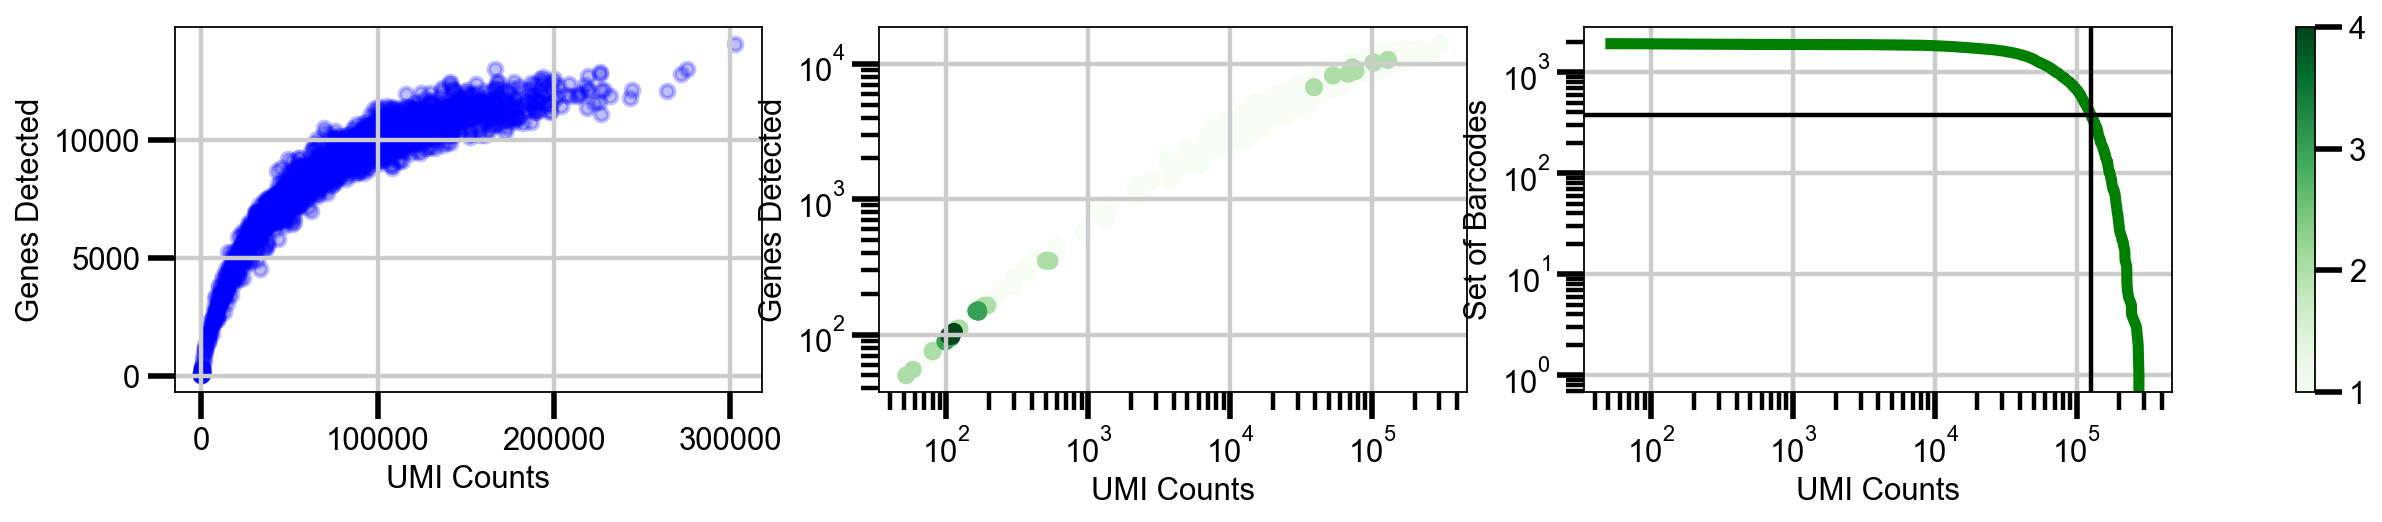

In [47]:
#### RECREATE PLOTS THAT ARE GIVEN IN THE REPORT BY SCILAB!

#Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(1,3)
x = np.asarray(adata.X.sum(axis=1))
y = np.asarray(np.sum(adata.X>0, axis=1))
ax[0].scatter(x, y, color="b", alpha=0.25)
ax[0].set_ylabel("Genes Detected")
ax[0].set_xlabel("UMI Counts")
#ax.set_xscale('log')
#ax.set_yscale('log')

#histogram definition
bins = [1500, 1500] # number of bins
# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax[1].scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("UMI Counts")
ax[1].set_ylabel("Genes Detected")


expected_num_cells =  380#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

ax[2].set_xlabel("UMI Counts")
ax[2].set_ylabel("Set of Barcodes")

#plt.grid(True, which="both")

fig.set_size_inches([20,3])
plt.show()
# fig.savefig(os.path.join(figure_path , 'QC_UMI_genes_counts_pre_filtering.png'))

In [48]:
# count mitochondrial genes
cnt = 0
for gene in adata.var["gene_name"].values:
    if gene.startswith('mt-'):
        cnt+=1
print(f"total mitochondrial: {cnt}")

total mitochondrial: 37


normalizing counts per cell
    finished (0:00:00)


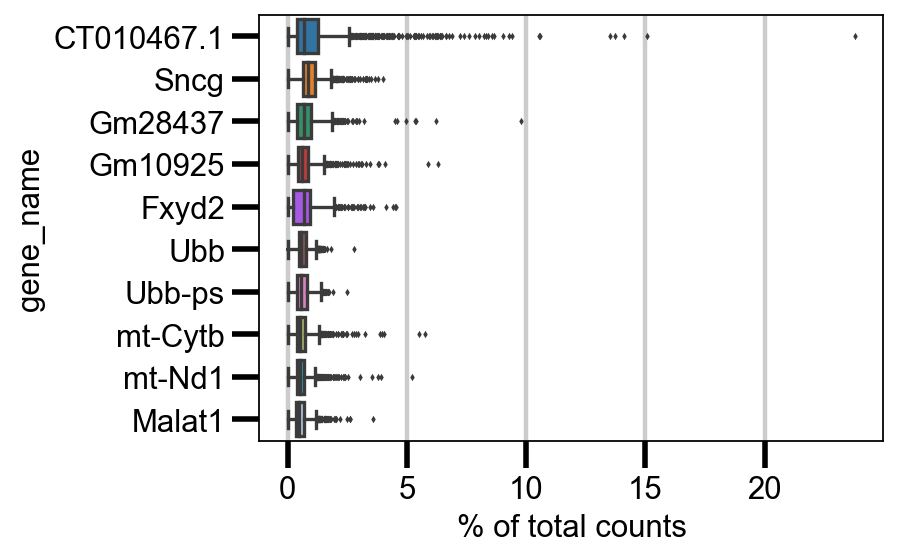

In [49]:
sc.pl.highest_expr_genes(adata, n_top=10, )

In [50]:
# Filter cells according to identified QC thresholds:
print('Total number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_counts = 10000)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Total number of cells before: 1920
filtered out 92 cells that have less than 10000 counts
Total number of cells after: 1828


In [51]:
print('Number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 3000)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 1828
filtered out 2 cells that have less than 3000 genes expressed
Total number of cells after: 1826


In [52]:
print('Number of genes before: {:d}'.format(adata.n_vars))
sc.pp.filter_genes(adata, min_cells=5)
print('Number of genes after: {:d}'.format(adata.n_vars))

Number of genes before: 39920
filtered out 11033 genes that are detected in less than 5 cells
Number of genes after: 28887


In [53]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

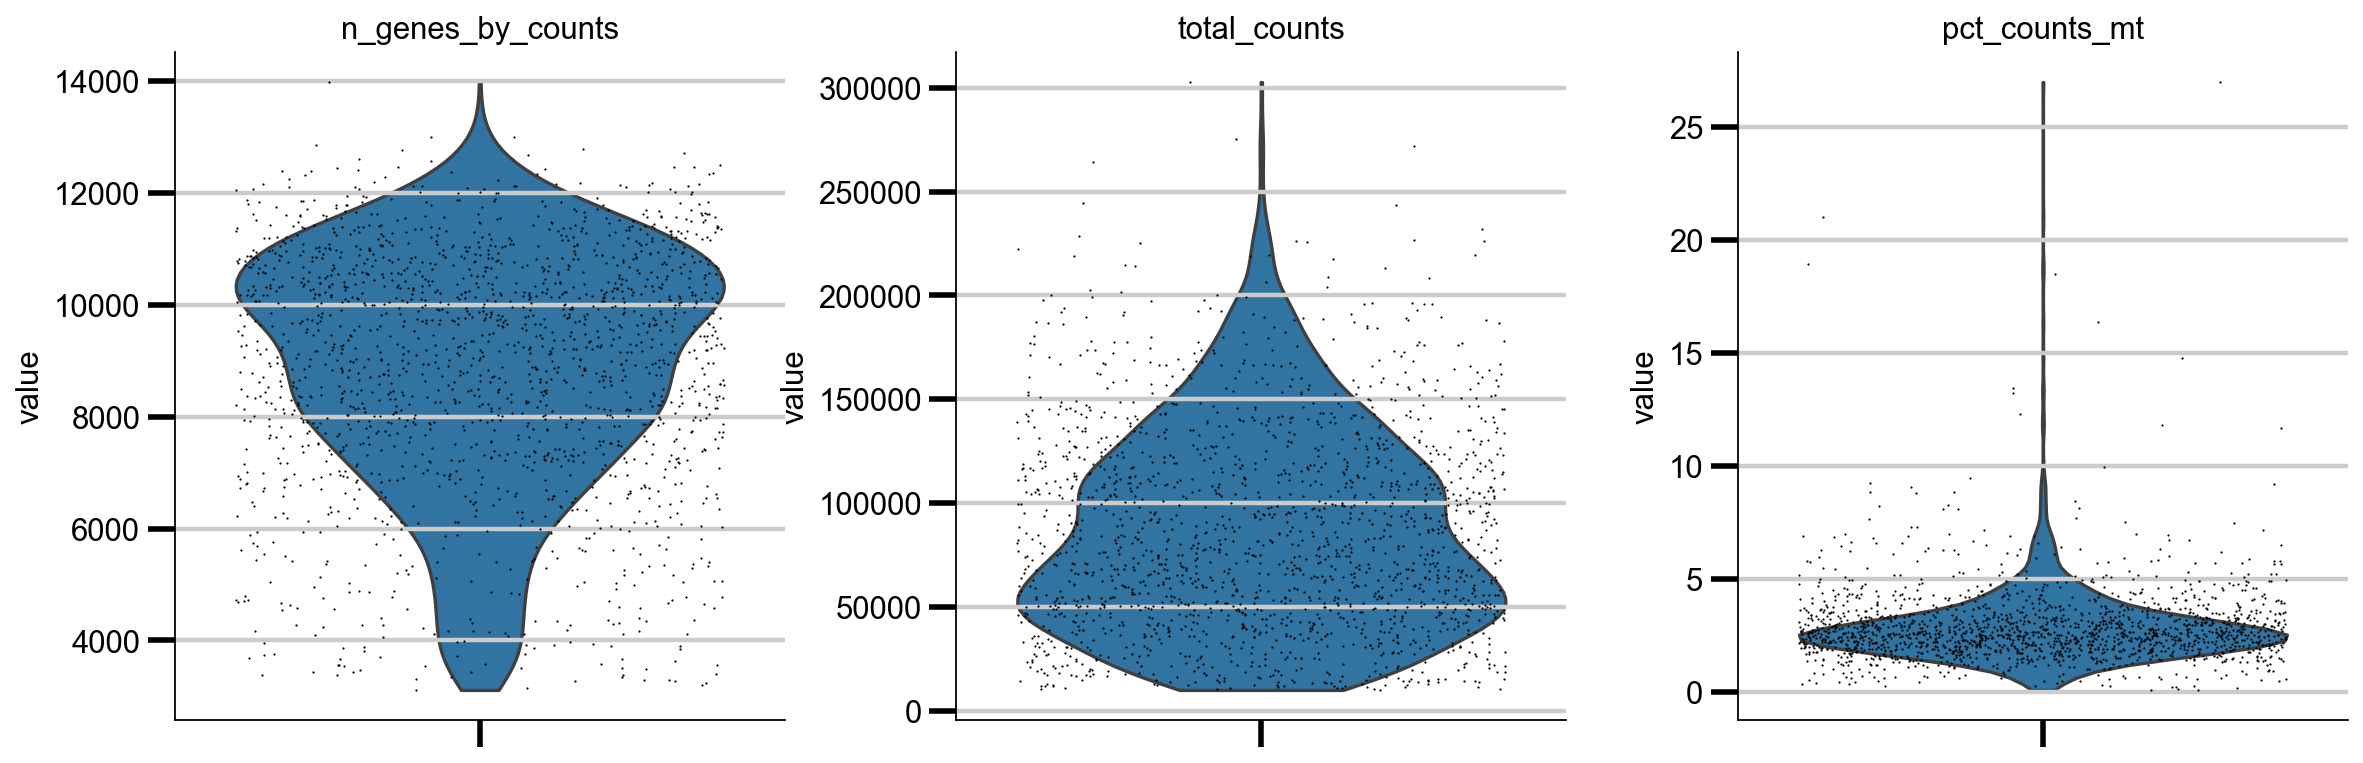

In [54]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [55]:
# Do the filtering by slicing the AnnData object
print('Number of cells before: {:d}'.format(adata.n_obs))
# keep only below 5% mitochondrial
adata = adata[adata.obs.pct_counts_mt < 5, :]
print('Number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 1826
Number of cells after: 1706


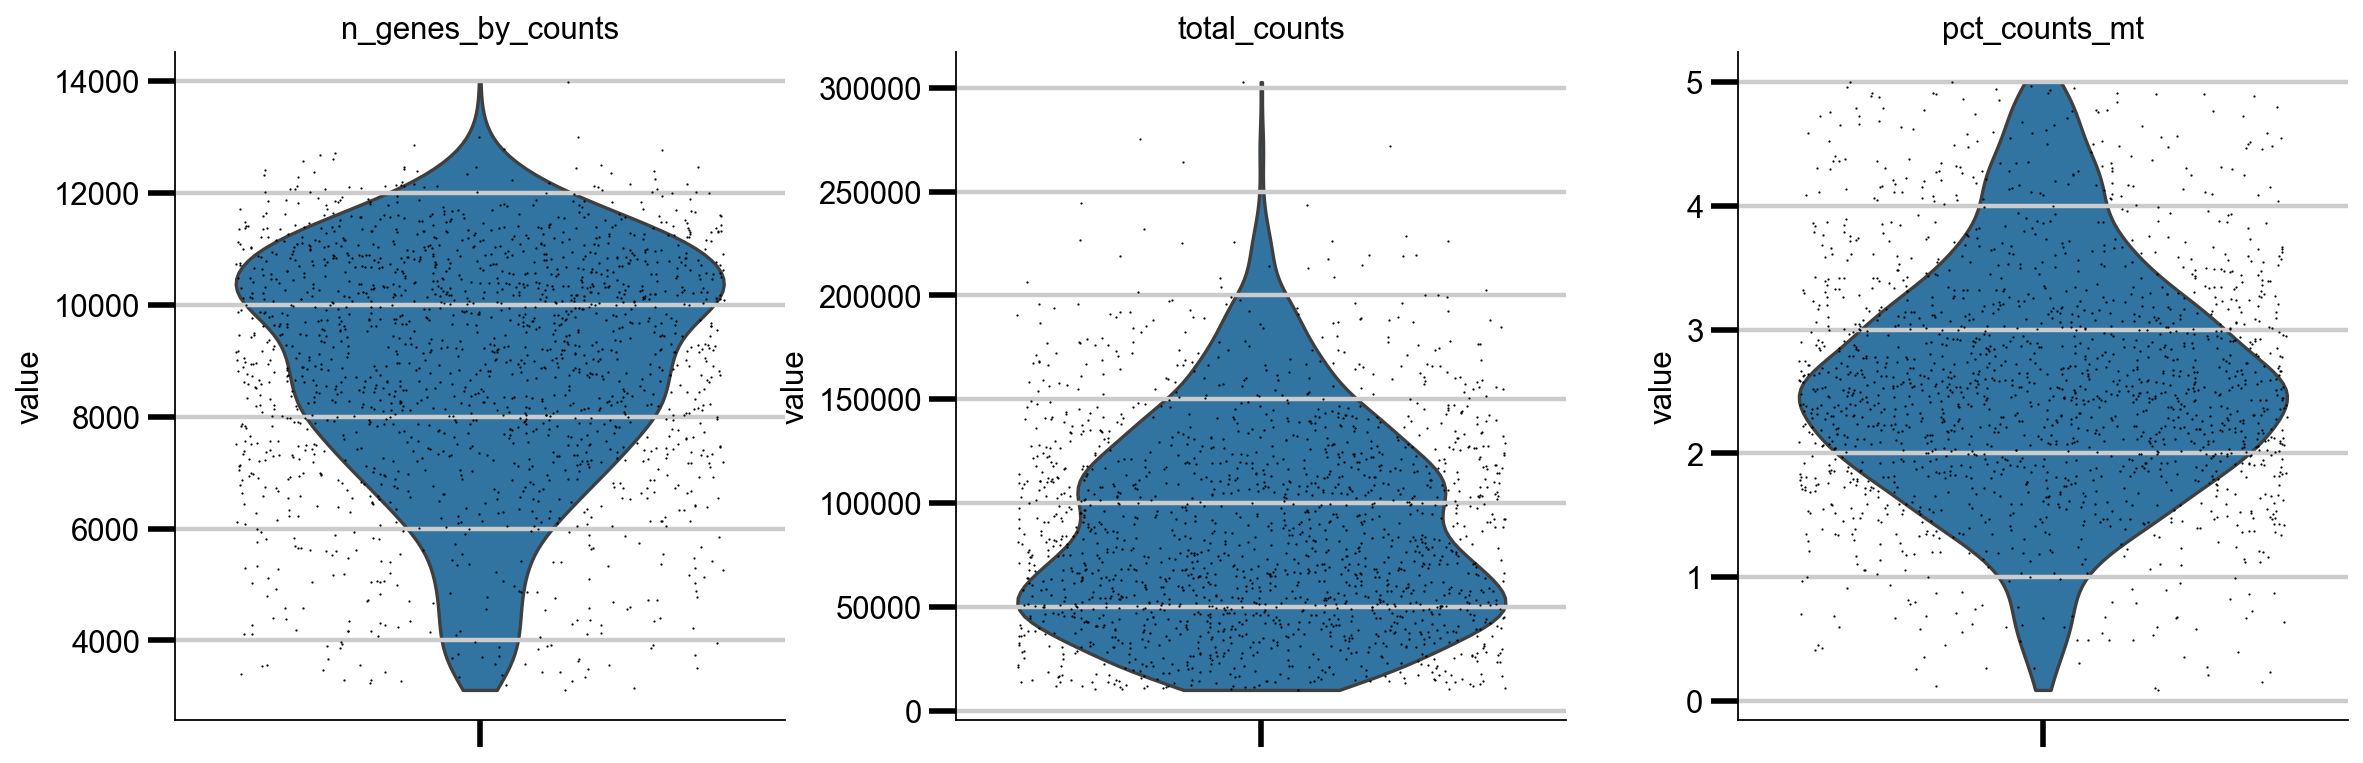

In [56]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [57]:
# save all genes before filtering highly variable
adata.write_h5ad(
    os.path.join(output_path, campari_file_all_genes),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

In [58]:
# Normalize 
# Seurat tutorial uses: LogNormalize: 
# Feature counts for each cell are divided by the total counts for that cell and multiplied by the scale.factor. 
# This is then natural-log transformed using log1p
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [59]:
# Logarithmize the data
sc.pp.log1p(adata)

In [60]:
# select only highly variable genes
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=15000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 15000


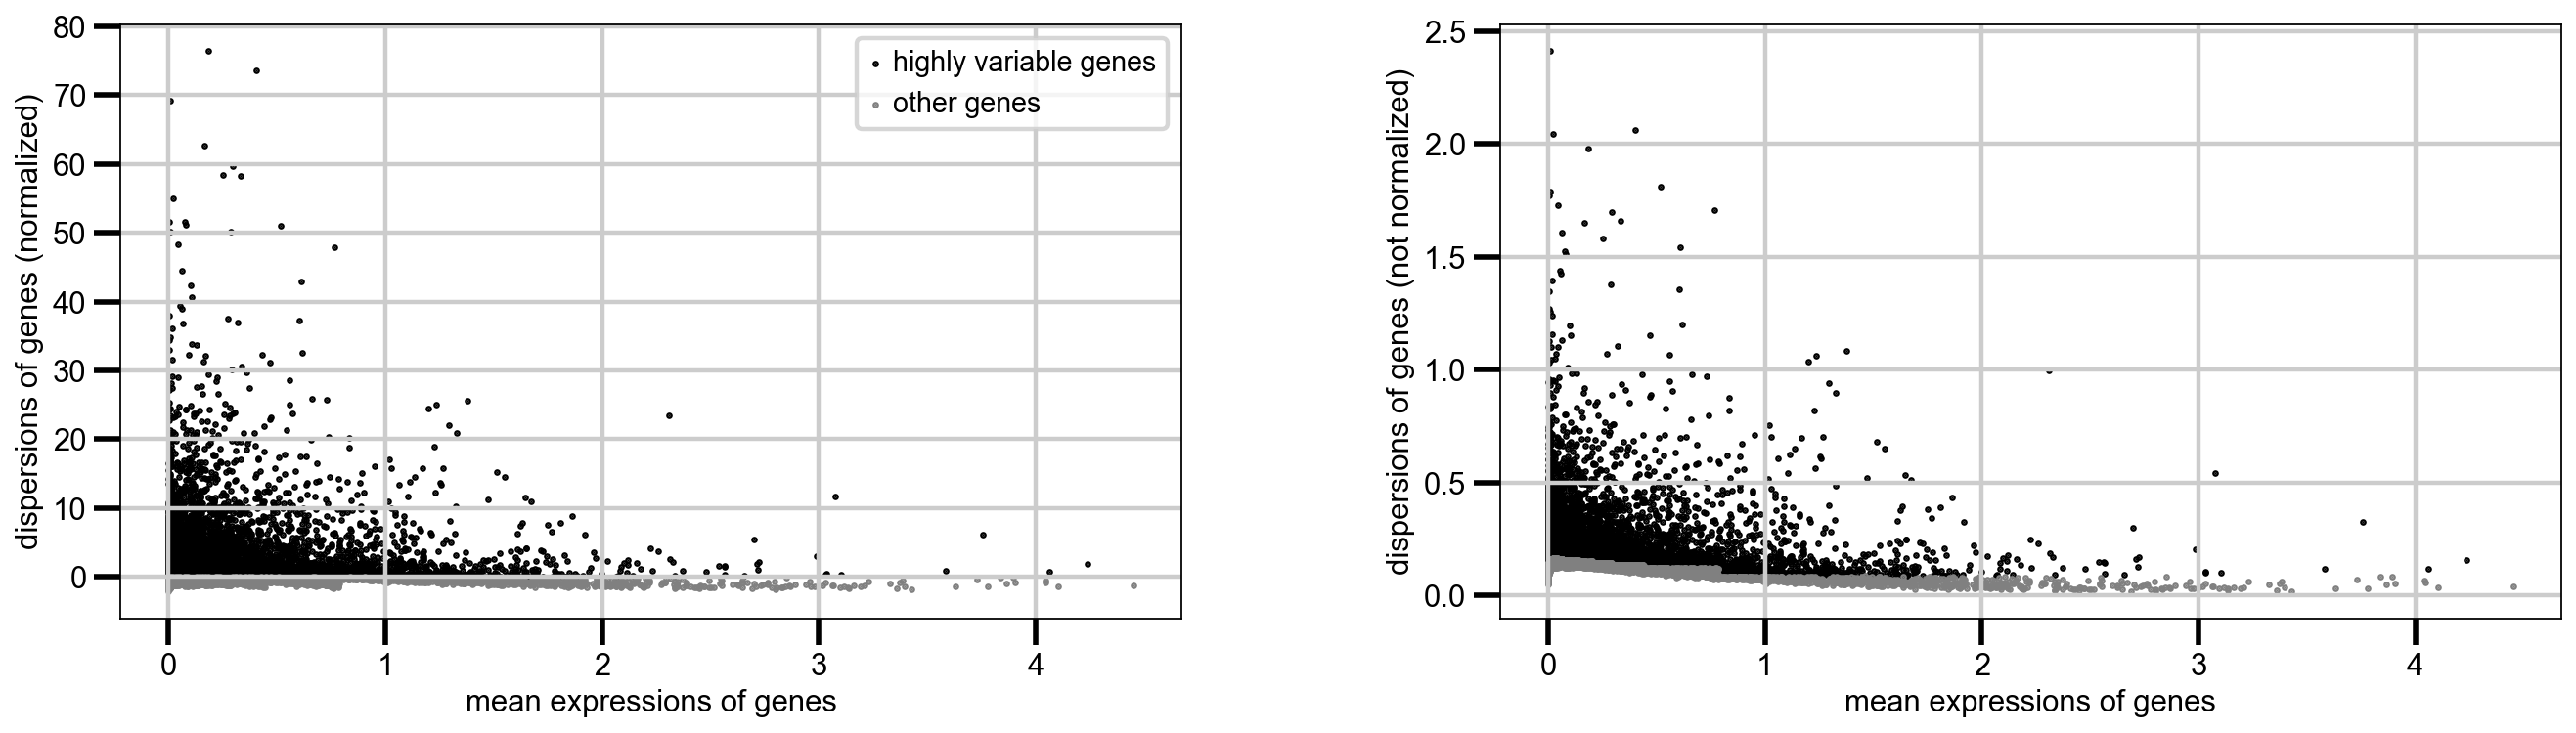

(1706, 28887)


In [61]:
from matplotlib import rcParams

rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

print(adata.shape)

In [62]:
# You can get back an AnnData of the object in .raw by calling .raw.to_adata()
# If you don’t proceed below with correcting the data with sc.pp.regress_out and scaling it via sc.pp.scale, you can also get away without using .raw at all
adata.raw = adata

In [63]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:36)


In [64]:
# export normalized data
adata.write_h5ad(
    os.path.join(output_path,campari_file),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)